# The Surprise Library

In the previous notebook, we built **Content Based** and **Memory-Based Collaborative Filtering** models, and we saw their limited capacity in terms of what they can and cannot do. 

As a reminder, we are focusing on the `rmse` as the metric to evaluate our models, as well as the a threshold of **3 seconds** to output predictions. Previously, we saw a RMSE of 3.2, which on the surface may seem to be alright, however if we interpret it, it means that our memory-based collaborative filtering approach predicts the rating to be either **64%** more or less than the actual rating. This is not ideal, and there are a few possible reasons for this. 

1. Our model has overfit on training data.
* To deal with this, we would need to apply some dimensionality reduction techniques to improve the `rmse` score.

2. Doesn't scale well to massive datasets. 
* The dataset we have elected to use is the 100k dataset, and in reality, there are many many more times larger datasets in real-life production scenarios, the largest dataset offered by [movielens is 45M](https://grouplens.org/datasets/movielens/).

To achieve this, we will make use of the `SurPrise` library that is available in python for building and analyzing recommender systems that deal with explicit rating data. [A paper going into much greater detail about this awesome library is cited here!](https://doi.org/10.21105/joss.02174). This is relevant here as we have a 100 Thousand dataset with explicit rating for movies. The library contains a mixture of memory based and model based techniques, for example, the `KNN` models are memory based, and the `SVD` models are model based. 

Once we have selected our best model, we will go more in depth into that model.

*The name SurPRISE (roughly :) ) stands for Simple Python RecommendatIon System Engine*

This is the **THIRD** of five notebooks:<br>
[1. Data Exploration and EDA](1_Data_Exploration_and_EDA.ipynb)</br>
[2. Simple Content and Collaborative Filtering Methods](2_Simple_Content_and_Collaborative_Filtering_Models.ipynb)</br>
**3. Surprise Library Models (Current Notebook)**</br>
[4. Deep Learning Part 1 ](4_Deep_Learning_Part_1_(Basic).ipynb)</br>
[5. Deep Learning Part 2](5_Deep_Learning_Part_2_(Introducing_more_features_and_layers).ipynb)</br>

# Contents of this notebook:
[1. Imports](#Imports)<br>
[2. Reading in the data](#Reading-in-the-data)<br>
[3. Base Models](#Base-Models)<br>
[4. Tuning our best models](#Tuning-our-best-models)<br>
* [KNNBaseline Tuning](#KNNBaseline-Tuning)<br>
* [SVD Tuning](#SVD-Tuning)<br>
* [SVDpp Tuning](#SVDpp-Tuning)<br>

[5. Best Model Selection](#Best-Model-Selection)<br>
[6. The SVD Model](#The-SVD-Model)<br>

[7. Best Model Evaluation](#Best-Model-Evaluation)<br>
* [Get top n Predictions](#Get-top-n-Predictions)<br>
* [Error Analysis](#Error-Analysis)<br>
* [Overall Model Evaluation](#Overall-Model-Evaluation)<br>

---

# Imports

In [1]:
from surprise import (BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, SVDpp, NMF, SlopeOne, 
CoClustering)
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.accuracy import rmse, mae
from sklearn.metrics import mean_squared_error

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from collections import defaultdict
import statistics

In order to have reproducible results, we will create a random seed for this whole notebook.

In [4]:
import random

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [129]:
# setting global font size for charts to be 12
plt.rcParams['font.size'] = 12

---

# Reading in the data

In [143]:
df = pd.read_csv('./datasets/merged_users+movies.csv')

In [61]:
movie_df = pd.read_csv('./datasets/movies.csv')

In [6]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure Animation Children Comedy Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure Animation Children Comedy Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure Animation Children Comedy Fantasy


Even though the surprise library has been modeled and inspired by the excellent scikit library, the way some of the methods are used is different since we are dealing with a library that has been built specifically for recommender systems for datasets with explicit ratings. We will make use of the documentation found [here](http://surpriselib.com/).

In [7]:
# we will use the min and max ratings observed from our data
reader = Reader(rating_scale=(min(df['rating']), max(df['rating'])))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

Now we are ready to start modeling.

---

# Base Models

Now we are ready to start modeling. Due to the way the surprise library is built, the way we fit our data for our model with and without `GridSearchCV` is different. So we will need to redefine our `data` once we are ready to perform hyper parameter tuning. Let's start with all the base models first.

In [92]:
# Creating models dict for modeling function
models = {'baseline': BaselineOnly(),
          'knn_basic': KNNBasic(),
          'knn_means': KNNWithMeans(),
          'knn_zscore': KNNWithZScore(),
          'knn_baseline': KNNBaseline(),
          'svd': SVD(),
          'svdpp': SVDpp(),
          'nmf': NMF(),
          'slope': SlopeOne(),
          'cluster': CoClustering(),
         }

In [93]:
# creating empty list to store modeling results
model_eval = []

In [404]:
# Function to run model -- input model
def get_base_model_scores(model_name,
                          mod):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str)."""
    
    # empty dict for appending results
    results = {}
    
    cross_val_model = cross_validate(models[mod],
                                     data,
                                     measures=['rmse'],
                                     cv=3,
                                     return_train_measures=True,
                                     n_jobs=-1,
                                     verbose=False
                                    )
    
    # adding model metrics to results
    results['model_name'] = model_name
    results['model'] = mod
    results['train_rmse'] = cross_val_model['train_rmse'].mean()
    results['test_rmse'] = cross_val_model['test_rmse'].mean()
    
    # using statistics method as the below two attributes
    # are tuples, so the .mean() method will not work
    # the above are arrays, so the .mean() method works
    
    results['fit_time'] = statistics.mean(cross_val_model['fit_time'])
    results['test_time'] = statistics.mean(cross_val_model['test_time'])
    
    # adding model scores to evaluation list
    model_eval.append(results)
    print('Base model fit is complete.')
    
    return cross_val_model

Now that we have our modeling function, we will get all of our baseline model scores.

In [414]:
base_baseline_only = get_base_model_scores('base_baseline_only', 'baseline')

Base model fit is complete.


In [413]:
base_knn_basic = get_base_model_scores('base_knn_basic', 'knn_basic')

Base model fit is complete.


In [412]:
base_knn_means = get_base_model_scores('base_knn_means', 'knn_means')

Base model fit is complete.


In [411]:
base_knn_zscore = get_base_model_scores('base_knn_zscore', 'knn_zscore')

Base model fit is complete.


In [410]:
base_knn_baseline = get_base_model_scores('base_knn_baseline', 'knn_baseline')

Base model fit is complete.


In [409]:
base_svd = get_base_model_scores('base_svd', 'svd')

Base model fit is complete.


In [408]:
base_svdpp = get_base_model_scores('base_svdpp', 'svdpp')

Base model fit is complete.


In [407]:
base_nmf = get_base_model_scores('base_nmf', 'nmf')

Base model fit is complete.


In [406]:
base_slop = get_base_model_scores('base_slop', 'slope')

Base model fit is complete.


In [405]:
base_cluster = get_base_model_scores('base_cluster', 'cluster')

Base model fit is complete.


That was easy! Luckily the `SurPRISE` library, and the custom function we wrote is doing all the heavy lifting for us, it makes our code look very nice and clean. 

Now let's take a look at the results we have so far.

In [417]:
# creating dataframe from model_eval scores
base_model_scores = pd.DataFrame(model_eval)

In [418]:
# sorting by 'test_rmse' metric
base_model_scores.sort_values('test_rmse')

,model_name,model,train_rmse,test_rmse,fit_time,test_time
6,base_svdpp,svdpp,0.675951,0.866679,302.668346,6.992896
0,base_baseline_only,baseline,0.837641,0.876241,0.050725,0.111516
5,base_svd,svd,0.639353,0.879827,2.926874,0.167982
4,base_knn_baseline,knn_baseline,0.655359,0.882639,0.160189,1.926270
3,base_knn_zscore,knn_zscore,0.668391,0.903679,0.157216,1.621699
2,base_knn_means,knn_means,0.673119,0.904506,0.111510,1.488612
8,base_slop,slope,0.551231,0.909538,2.661436,4.934569
7,base_nmf,nmf,0.577744,0.937035,3.727779,0.152249
9,base_cluster,cluster,0.812592,0.954283,1.698625,0.132729
1,base_knn_basic,knn_basic,0.697346,0.959823,0.094301,1.339809


Based on the above table, we can see that the lowest(below 90%) `rmse` scores are for the `SVD++`, `BaselineOnly`, `SVD` amd `KNNBaseline`. As `BaselineOnly` predicts a rating based on the distribution of the training set, (assumed to be normal), because of this, we will not choose this model for further tuning. The reason for this is so that this model could be applicable to other movie rating datasets, and may follow a different distribution, (*not normal*).

Instead, we will focus on the `SVD++`, `SVD` and `KNNBaseline`.

In the following section, we will tune the hyperparameters of these three models using the `surprise` library `GridSearchCV` method.

Considering that the base `SVD++` model took 302s (5mins) on average to fit 1 fold, we will start with `SVD`, then move on to `KNNBaseline` and then move to `SVD++`. `SVD++` hyperparameters tuning will most likley take a lot of time, even if it is our best performing model so far.

---

# Tuning our best models

Since we are using `GridSearchCV`, we will need to make some changes to our modeling function we used previously. We will also need to re-instantiate our models in the way that is specifically required for `GridSearchCV`. 

In [440]:
# as per the surprise documentation, the models
# must be instatiated in GridSearchCV without
# parentheses
model_tuned = {'knn_baseline': KNNBaseline,
               'svd': SVD,
               'svdpp': SVDpp,
              }

In [319]:
# Function to run model -- input model
def tuned_model_scores(model_name, 
                       mod, 
                       mod_params={}):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str), 
    model params(dict, optional)."""
    
    # empty dict for appending results
    results = {}
    
    # instantiate GridSearchCV
    gs = GridSearchCV(model_tuned[mod], 
                      param_grid=mod_params,
                      measures=['rmse'],
                      cv=3,
                      n_jobs=-1,
                      return_train_measures=True
                     )

    # fit model
    gs.fit(data)
    
    temp_df = pd.DataFrame(gs.cv_results)
    num_fits = len(temp_df)*3

    temp_df = temp_df.loc[gs.best_index['rmse'], 
                          ['mean_train_rmse', 
                           'mean_test_rmse', 
                           'mean_fit_time', 
                           'mean_test_time', 
                           'params']].values.tolist()
    
    # Retrieve metrics and add to results
    results['model_name'] = model_name
    results['model'] = mod
    results['train_rmse'] = temp_df[0]
    results['test_rmse'] = temp_df[1]
    results['fit_time'] = temp_df[2]
    results['test_time'] = temp_df[3]
    
    # add results to list for model evaluation later
    model_eval.append(results)
    
    print(f'{num_fits} fits have been completed.')
    
    return gs

With this function, we are now ready to begin with hyperparameter tuning for our 3 selected models.

## SVD Tuning

In [304]:
# defining SVD parameters
svd_params = {'n_factors': [80, 90, 100, 110, 120], 
              'n_epochs': [15, 20, 25, 30, 35], 
              'biased': [True, False], 
              'lr_all': [0.003, 0.004, 0.005, 0.006, 0.007],
              'reg_all': [0.01, 0.02, 0.03, 0.04]
             }

In [338]:
# first tuning attempt
svd_tuned_1 = tuned_model_scores('svd_tuned_1', 
                                 'svd', 
                                 mod_params=svd_params)

3000 fits have been completed.


In [339]:
# getting best params
svd_tuned_1.best_params

{'rmse': {'n_factors': 80,
  'n_epochs': 25,
  'biased': True,
  'lr_all': 0.007,
  'reg_all': 0.04}}

In [420]:
# getting rmse, base rmse was 0.879827
svd_tuned_1.best_score

{'rmse': 0.8705537233081375}

We have managed to see an improvement in `rmse` by almost **0.01**. <br>
However, if we compare the best parameters chosen by `GridSeachCV`, we can see that more tuning can be done for `n_factors`, `lr_all`, and `reg_all`. Let's continue tuning the model, by redefining new params for `GridSearchCV` to search through.

In [341]:
# redefining new params based on previous tuned model
svd_params_V2 = {'n_factors': [30, 50, 80], 
                 'n_epochs': [25], 
                 'biased': [True], 
                 'lr_all': [0.007, 0.008, 0.009],
                 'reg_all': [0.04, 0.05, 0.06, 0.07, 0.08]
                }

In [342]:
# second tuning attempt
svd_tuned_2 = tuned_model_scores('svd_tuned_2', 
                                 'svd', 
                                 mod_params=svd_params_V2)

135 fits have been completed.


In [344]:
svd_tuned_2.best_params

{'rmse': {'n_factors': 80,
  'n_epochs': 25,
  'biased': True,
  'lr_all': 0.009,
  'reg_all': 0.08}}

In [421]:
# getting rmse, base rmse was 0.879827
svd_tuned_2.best_score

{'rmse': 0.8655018320388175}

We have managed to see an improvement in `rmse` by **0.005** more. <br>
Again, if we compare the best parameters chosen by `GridSeachCV`, we can see that more tuning can be done for `lr_all`, and `reg_all`. Let's continue tuning the model, by redefining new params for `GridSearchCV` to search through.

In [346]:
# redefining new params based on previous tuned model
svd_params_V3 = {'n_factors': [60, 70, 80], 
                 'n_epochs': [25], 
                 'biased': [True], 
                 'lr_all': [0.0085, 0.009, 0.01],
                 'reg_all': [0.075, 0.08, 0.09]
                }

In [347]:
# third tuning attempt
svd_tuned_3 = tuned_model_scores('svd_tuned_3', 
                                 'svd', 
                                 mod_params=svd_params_V3)

81 fits have been completed.


In [348]:
# getting best params
svd_tuned_3.best_params

{'rmse': {'n_factors': 80,
  'n_epochs': 25,
  'biased': True,
  'lr_all': 0.01,
  'reg_all': 0.075}}

In [422]:
# getting rmse, base rmse was 0.879827
svd_tuned_3.best_score

{'rmse': 0.8629833150886892}

We have managed to see an improvement in `rmse` by **0.003** more. <br>
Again, if we compare the best parameters chosen by `GridSeachCV`, we can see that more tuning can be done for `lr_all`. Let's continue tuning the model, by redefining new params for `GridSearchCV` to search through.

In [350]:
# redefining new params based on previous tuned model
svd_params_V4 = {'n_factors': [80], 
                 'n_epochs': [25], 
                 'biased': [True], 
                 'lr_all': [0.0095, 0.01, 0.012, 0.014],
                 'reg_all': [0.075]
                }

In [351]:
# fourth tuning attempt
svd_tuned_4 = tuned_model_scores('svd_tuned_4', 
                                 'svd', 
                                 mod_params=svd_params_V4)

12 fits have been completed.


In [353]:
# getting best params
svd_tuned_4.best_params

{'rmse': {'n_factors': 80,
  'n_epochs': 25,
  'biased': True,
  'lr_all': 0.014,
  'reg_all': 0.075}}

In [423]:
# getting rmse, base rmse was 0.879827
svd_tuned_4.best_score

{'rmse': 0.8621820643257244}

We have managed to see an improvement in `rmse` by **0.0008** more. This is now a very small improvement in the model. <br>
Again, if we compare the best parameters chosen by `GridSeachCV`, we can see that more tuning can be done for `lr_all`. Let's make one final attempt to tune our `SVD` model. 

In [ ]:
# redefining new params based on previous tuned model
svd_params_V5 = {'n_factors': [80], 
                 'n_epochs': [25], 
                 'biased': [True], 
                 'lr_all': [0.014, 0.018, 0.02, 0.03, 0.05],
                 'reg_all': [0.075]
                }

In [367]:
# fifth tuning attempt
svd_tuned_5 = tuned_model_scores('svd_tuned_5', 
                                 'svd', 
                                 mod_params=svd_params_V5)

15 fits have been completed.


In [368]:
svd_tuned_5.best_params

{'rmse': {'n_factors': 80,
  'n_epochs': 25,
  'biased': True,
  'lr_all': 0.014,
  'reg_all': 0.075}}

In [380]:
svd_tuned_5.best_score

{'rmse': 0.861168716056909}

We have managed to see an improvement in `rmse` by **0.001** more. Oddly enough we are seeing the same parameters.<br>
Most likely we are close to the best possible model, if not the best for `SVD`. As such, this will be our final `SVD` tuned model. Let's take a look at all the scores so far.

In [34]:
model_scores = pd.DataFrame(model_eval)
model_scores[model_scores['model'] == 'svd']

,model_name,model,train_rmse,test_rmse,fit_time,test_time
5,base_svd,svd,0.639353,0.879827,2.926874,0.167982
10,svd_tuned_1,svd,0.569728,0.870554,7.784396,0.455209
11,svd_tuned_2,svd,0.644704,0.865502,6.249327,0.207198
12,svd_tuned_3,svd,0.603065,0.862983,7.057509,0.376290
13,svd_tuned_4,svd,0.521653,0.862182,6.787233,0.303089
14,svd_tuned_5,svd,0.521521,0.861169,6.284704,0.372672


As we can see from the above, we have managed to see an improvement in our `test_rmse` score for the `SVD` model, by **0.01866**. I believe we have pushed this model as far as it can go.

---

## KNNBaseline Tuning

Let's move on to tuning the `KNNBaseline` model.

In [438]:
# creating separate params for the two different baseline options

# als baseline params
knnbase_params_als = {'k': [20, 30, 40, 50, 60], 
                      'min_k': [1, 2, 3],
                      'bsl_options': {'method': ['als'],
                                      'n_epochs': [8, 9, 10, 11, 12], 
                                      'reg_u': [13, 14, 15, 16, 17],
                                      'reg_i': [8, 9, 10, 11, 12]
                                  }
                     }

# sgd baseline params
knnbase_params_sgd = {'k': [20, 30, 40, 50, 60], 
                      'min_k': [1, 2, 3], 
                      'bsl_options': {'method': ['sgd'], 
                                      'learning_rate': [0.00003, 0.00004, 0.00005, 0.00006, 0.00007]
                                     }
                     }

In [441]:
knn_als_tuned_1 = tuned_model_scores('knn_als_tuned_1', 
                                     'knn_baseline', 
                                     mod_params=knnbase_params_als)

5625 fits have been completed.


In [442]:
knn_sgd_tuned_1 = tuned_model_scores('knn_sgd_tuned_1', 
                                     'knn_baseline', 
                                     mod_params=knnbase_params_sgd)

225 fits have been completed.


After evaluating the two baseline methods scores, I have decided to continue tuning the `als` baseline as that is the one that showed most improvement.

In [444]:
knn_als_tuned_1.best_params

{'rmse': {'k': 30,
  'min_k': 3,
  'bsl_options': {'method': 'als', 'n_epochs': 12, 'reg_u': 13, 'reg_i': 8}}}

In [446]:
# redefining params based on preivious run
knnbase_params_als_V2 = {'k': [30], 
                         'min_k': [3, 4, 5], 
                         'bsl_options': {'method': ['als'], 
                                         'n_epochs': [12, 13, 14], 
                                         'reg_u': [11, 12, 13], 
                                         'reg_i': [6, 7, 8] 
                                        }
                        }

In [447]:
knn_als_tuned_2 = tuned_model_scores('knn_als_tuned_2', 
                                     'knn_baseline', 
                                     mod_params=knnbase_params_als_V2)

243 fits have been completed.


In [450]:
knn_als_tuned_2.best_score

{'rmse': 0.8700311882994001}

In [451]:
knn_als_tuned_2.best_params

{'rmse': {'k': 30,
  'min_k': 5,
  'bsl_options': {'method': 'als', 'n_epochs': 14, 'reg_u': 11, 'reg_i': 6}}}

Note the following cell had an error while writing markdown, the tuning was run, and you can see the `test_rmse` score below.

In [237]:
# redefining params based on preivious run
knnbase_params_als_V3 = {'k': [30], 
                         'min_k': [5, 10, 15], 
                         'bsl_options': {'method': ['als'], 
                                         'n_epochs': [14, 18, 22], 
                                         'reg_u': [7, 9, 11], 
                                         'reg_i': [2, 4, 6] 
                                        }
                        }

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 8)

In [453]:
knn_als_tuned_3 = tuned_model_scores('knn_als_tuned_3', 
                                     'knn_baseline', 
                                     mod_params=knnbase_params_als_V3)

243 fits have been completed.


In [455]:
knn_als_tuned_3.best_params

{'rmse': {'k': 30,
  'min_k': 10,
  'bsl_options': {'method': 'als', 'n_epochs': 22, 'reg_u': 7, 'reg_i': 2}}}

In [457]:
knn_als_tuned_3.best_score

{'rmse': 0.86391808648022}

Here we can see that there is more tuning we can do for `n_epochs`, `reg_u`, and `reg_i`.

In [458]:
# redefining params based on preivious run
knnbase_params_als_V4 = {'k': [30], 
                         'min_k': [10], 
                         'bsl_options': {'method': ['als'], 
                                         'n_epochs': [22, 25, 30], 
                                         'reg_u': [3, 5, 7], 
                                         'reg_i': [0.5, 1, 1.5, 2] 
                                        }
                        }

In [459]:
knn_als_tuned_4 = tuned_model_scores('knn_als_tuned_4', 
                                     'knn_baseline', 
                                     mod_params=knnbase_params_als_V4)

108 fits have been completed.


In [461]:
knn_als_tuned_4.best_params

{'rmse': {'k': 30,
  'min_k': 10,
  'bsl_options': {'method': 'als', 'n_epochs': 30, 'reg_u': 7, 'reg_i': 2}}}

In [462]:
knn_als_tuned_4.best_score

{'rmse': 0.8647604619133166}

We will attempt tuning one more time, as I think we can make just a bit more improvement on this model.

In [483]:
# redefining params based on preivious run
knnbase_params_als_V5 = {'k': [30], 
                         'min_k': [10], 
                         'bsl_options': {'method': ['als'], 
                                         'n_epochs': [30, 50, 100, 120], 
                                         'reg_u': [7], 
                                         'reg_i': [2] 
                                        }
                        }

In [484]:
knn_als_tuned_5 = tuned_model_scores('knn_als_tuned_5', 
                                     'knn_baseline', 
                                     mod_params=knnbase_params_als_V5)

12 fits have been completed.


In [485]:
knn_als_tuned_5.best_score

{'rmse': 0.8637914129499696}

In [486]:
knn_als_tuned_5.best_params

{'rmse': {'k': 30,
  'min_k': 10,
  'bsl_options': {'method': 'als', 'n_epochs': 120, 'reg_u': 7, 'reg_i': 2}}}

Based on this result here, after tuning our model, we still see that the `SVD` tuned model has the lowest `rmse` score so far. We will stop tuning this model here. <br>
Let's evaluate the score of this model vs all the tuning iterations that we have done so far.

In [32]:
model_scores = pd.DataFrame(model_eval)
model_scores[model_scores['model'] == 'knn_baseline']

,model_name,model,train_rmse,test_rmse,fit_time,test_time
4,base_knn_baseline,knn_baseline,0.655359,0.882639,0.160189,1.926270
15,knn_als_tuned_1,knn_baseline,0.684323,0.872226,0.390730,4.714972
16,knn_sgd_tuned_1,knn_baseline,0.691578,0.909773,0.749931,4.241354
17,knn_als_tuned_2,knn_baseline,0.701165,0.870031,0.392658,4.737912
18,knn_als_tuned_3,knn_baseline,0.701315,0.863918,0.667222,4.990317
19,knn_als_tuned_4,knn_baseline,0.701389,0.864760,0.633972,5.162850
20,knn_als_tuned_5,knn_baseline,0.701122,0.863791,1.595689,3.787077


From this we can see that we have improved the `knn_baseline` model `test_rmse` performance by **0.0188**. This is a great improvement, however our best model so far is the `SVD` tuned model that we tuned before.<br>
Let's move on to our final model we are going to tune from the surprise library, `SVD++`.

---

## SVDpp Tuning

When we ran the base models, our `SVD++` model took the longest time for fitting. **302s** to be exact. This was much longer than any of the other models. As such, let's first try out the hyperparamters that we have tuned for our `SVD` model, and see if we can use that to help us tune the `SVD++` model.

In [498]:
svd_tuned_5.best_params

{'rmse': {'n_factors': 80,
  'n_epochs': 25,
  'biased': True,
  'lr_all': 0.014,
  'reg_all': 0.075}}

In [501]:
svdpp_params = {'n_factors': [80], 
                'n_epochs': [25], 
                'lr_all': [0.014],
                'reg_all': [0.075], 
                'init_mean': [0, 5, 10], 
                'init_std_dev': [0.05, 0.1, 0.2]
               }

In [502]:
svdpp_tuned_1 = tuned_model_scores('svdpp_tuned_1', 
                                   'svdpp', 
                                   mod_params=svdpp_params
                                  )

27 fits have been completed.


In [503]:
svdpp_tuned_1.best_score

{'rmse': 0.8552280403135537}

In [504]:
svdpp_tuned_1.best_params

{'rmse': {'n_factors': 80,
  'n_epochs': 25,
  'lr_all': 0.014,
  'reg_all': 0.075,
  'init_mean': 0,
  'init_std_dev': 0.05}}

This fit took a couple of hours, so let's just try one more tuning attempt. So far this is the best model we have with the lowest `test_rmse` score.

In [507]:
svdpp_params_V2 = {'n_factors': [80], 
                   'n_epochs': [25], 
                   'lr_all': [0.014], 
                   'reg_all': [0.075], 
                   'init_mean': [0], 
                   'init_std_dev': [0.01, 0.025, 0.05]
                  }

In [508]:
svdpp_tuned_2 = tuned_model_scores('svdpp_tuned_2', 
                                   'svdpp', 
                                   mod_params=svdpp_params_V2
                                  )

9 fits have been completed.


Even the above 9 fits took close to 1 hour, the difficulty in tuning this model is to do with the time taken to tune it.

In [509]:
svdpp_tuned_2.best_params

{'rmse': {'n_factors': 80,
  'n_epochs': 25,
  'lr_all': 0.014,
  'reg_all': 0.075,
  'init_mean': 0,
  'init_std_dev': 0.025}}

In [510]:
svdpp_tuned_2.best_score

{'rmse': 0.853009224619437}

Let's take a look at all the `SVD++` scores so far.

In [29]:
model_scores = pd.DataFrame(model_eval)
model_scores[model_scores['model'] == 'svdpp']

,model_name,model,train_rmse,test_rmse,fit_time,test_time
6,base_svdpp,svdpp,0.675951,0.866679,302.668346,6.992896
21,svdpp_tuned_1,svdpp,0.543026,0.855228,2312.054770,18.585806
22,svdpp_tuned_2,svdpp,0.613652,0.853009,1801.290747,14.459661


From this we can see that we managed to improve our based model `test_rmse` score by **0.0137**. Considering the amount of time taken for this model to be trained, we will stop here for the tuning of this model.

---

# Best Model Selection

Now lets take a look at our three best models and compare the `test_rmse` scores.

In [31]:
model_scores.loc[[14, 20, 22],['model_name', 'model', 'test_rmse']]

,model_name,model,test_rmse
14,svd_tuned_5,svd,0.861169
20,knn_als_tuned_5,knn_baseline,0.863791
22,svdpp_tuned_2,svdpp,0.853009


From the above table, we can see that our best model is indeed the `SVD++` model with a `test_rmse` of **0.853**. Interpreting this with reference to our dataset, this means that our model is likely to predict a rating for a movie for a specific user within a range of plus-minus **17%** of the actual rating. <br>

Let's take a closer look at our best model and conduct some error analysis on our model.

---

We will Re-read in out data, and fit a new model with our best params for the error analysis.

In [8]:
# we will use the min and max ratings observed from our data
reader = Reader(rating_scale=(min(df['rating']), max(df['rating'])))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [9]:
# train test split on the dataset
trainset, testset = train_test_split(data,
                                    test_size=0.2,
                                    random_state=42
                                    )

We will define all the parameters of the `SVDpp` model as per the best params that we saw earlier.

In [13]:
# defining our best model
algo_best_model = SVDpp(n_factors=80, 
                        n_epochs=25, 
                        lr_all=0.014, 
                        reg_all=0.075, 
                        init_mean=0, 
                        init_std_dev=0.025, 
                        verbose=False
                       )

We will use the `%%time` method to check how long our model takes to output the predictions. As one of our criteria is a threshold of 3 seconds, we will need to check this.

In [14]:
# %% time will output the time taken for this cell to execute
%%time

# fit the model on the trainset
algo_best_model.fit(trainset);

Wall time: 21min 43s


In [22]:
# %% time will output the time taken for this cell to execute
%%time

# generate the predictions for SVDpp model
predictions_best_model = algo_best_model.test(testset)

Wall time: 5.26 s


In [16]:
# %% time will output the time taken for this cell to execute
%%time

# calculate the rmse score
rmse(predictions_best_model)

RMSE: 0.8442
Wall time: 27.9 ms


0.8442193432294534

Here we can see that the `rmse` is even better than when we were tuning. However the predictions took about **5.2 seconds** to generate. 

From the external research during our EDA, we found that loading times can differentiate the success of the webpage or app. The benchmark for us, to have a measure of success is **3 seconds**, and after running the predictions cell a couple of times, the lowest time I got was about **5.21s**. Due to a longer prediction time, this model may not be the best model when it comes to movie recommendations. Most users will just switch to another app where the predictions may occur faster.

Let's test out how long the `SVD` model *(our 2nd best model)* takes to create predictions.

We will instantiate our `SVD` model with the best params that we found for that model.

In [17]:
# instantiate SVD with best params
algo_2nd_best = SVD(n_factors=80,
                    n_epochs=25, 
                    biased=True,
                    lr_all=0.014,
                    reg_all=0.075,
                    verbose=False
                   )

In [18]:
# %% time will output the time taken for this cell to execute
%%time

# fit the model on the trainset
algo_2nd_best.fit(trainset);

Wall time: 3.53 s


In [19]:
# %% time will output the time taken for this cell to execute
%%time

# generate the predictions for SVD model
predictions_2nd_best = algo_2nd_best.test(testset)

Wall time: 177 ms


In [20]:
# %% time will output the time taken for this cell to execute
%%time

# calculate the rmse score
rmse(predictions_2nd_best)

RMSE: 0.8533
Wall time: 14.9 ms


0.8533256808314602

The `rmse` score of the `SVD` model is **0.8533**, compared to the score of **0.8442** for the `SVDpp` model. However the time taken to generate predictions via the `SVD` model is only 177ms. This is only **3.7%** of the time taken for the `SVDpp` model. In this case, I believe it makes the most sense for us to accept the `SVD` model as our best model, taking into accound the prediction load times.

## The SVD Model

## So what is the `SVD` model? 

At a high level, the Singular Value Decomposition(SVD) is an algorithm that decomposes a matrix A into two low rank matrix approximations.

![svd](images/matrix_factorization.png)

The columns `k` in the user matrix, as well as the columns `k` in the items matrix are latent factors that this method identifies. Thankfully for us, the `SurPRISE` library does all the heavy lifting for us behind the scenes and allows us to use simple `fit` methods.

The model calculates the rating for users with the following formula: 
![svd_formula](images/svd_formula2.png)

This approach was made popular during the Netflix Prize competition, by [Simon Funk](https://sifter.org/~simon/journal/20061211.html). Afterwhich the `SurPRISE` library was built and is currently maintained by [Nicolas Hug](http://nicolas-hug.com/).

Now that we know all this information, let's evaluate our best model.

---

# Best Model Evaluation

Now that we have our best model, we will evaluate it. Let's start by creating a custom function that gives us recommended movies for a `userId`. This custom function is written with the help of the documentation in the surprise library.

## Get top n Predictions

In [229]:
def get_top_n_userId(uid, predictions, n=10):
    """Return the top-N recommendation for a specific user from a set of 
    predictions.

    Args:
        userId(int): a specific userId e.g. 42.
        
        predictions(list of Prediction objects): The list of predictions, 
        asreturned by the test method of an algorithm.
        
        n(int): The number of recommendation to output this userId.
        Default is 10.

    Returns:
    A DataFrame where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    
    def get_top_n(predictions, n):
        """Return the top-N recommendation for each user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for userId, movieId, user_rating, pred_rating, _ in predictions:
            top_n[userId].append((movieId, pred_rating))

        # Then sort the predictions for each user and retrieve the k highest ones.
        for userId, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[userId] = user_ratings[:n]

        return top_n
    
    userId = uid
    predictions = predictions
    n = n
    user_recommendations = pd.DataFrame(columns=['userId', 
                                                 'movieId', 
                                                 'title', 
                                                 'genres'])
    # if statement to check if existing or new user
    if userId in df['userId'].unique():    
    
        top_n = get_top_n(predictions, n)

        # Print the recommended items for each user
        for uId, user_ratings in top_n.items():
            if uId == userId:
                user_recommendations['movieId'] = [movieId for (movieId, _) in user_ratings]


        user_recommendations['userId'] = user_recommendations['movieId'].map(
                                            lambda x: userId)
        user_recommendations['title'] = user_recommendations['movieId'].map(
                                        lambda x: movie_df.loc[movie_df['movieId'] == x,
                                                               'title'].values[0])

        user_recommendations['genres'] = user_recommendations['movieId'].map(
                                        lambda x: movie_df.loc[movie_df['movieId'] == x,
                                                               'genres'].values[0])
        return user_recommendations
    
    # since new user, return top n most popular movies
    else:
        most_popular_movies = movie_ratings[['title', 
                                             'movieId', 
                                             'genres',
                                             'mean_rating', 
                                             'times_rated']].\
        sort_values(by=['times_rated', 
                        'mean_rating',], 
                    ascending=False).head(n)
        
        # obtain values for each column from the most popular DataFrame
        user_recommendations['movieId'] = most_popular_movies['movieId']
        user_recommendations['title'] = most_popular_movies['title']
        user_recommendations['genres'] = most_popular_movies['genres']
        user_recommendations['userId'] = int(userId)
        
        return user_recommendations        

In [223]:
%%time
get_top_n_userId(342, predictions_2nd_best, n=10)

Wall time: 25.9 ms


,userId,movieId,title,genres
0,342,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action Adventure
1,342,1959,Out of Africa (1985),Drama Romance
2,342,2093,Return to Oz (1985),Adventure Children Fantasy
3,342,2861,For Love of the Game (1999),Comedy Drama
4,342,2881,Double Jeopardy (1999),Action Crime Drama Thriller
5,342,2676,Instinct (1999),Drama Thriller
6,342,2805,Mickey Blue Eyes (1999),Comedy Romance
7,342,2901,Phantasm (1979),Horror Sci-Fi
8,342,2723,Mystery Men (1999),Action Comedy Fantasy
9,342,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure Animation Children Comedy Fantasy


In [232]:
df[df['userId'] == 342].sort_values('rating', ascending=False).head(10)

,userId,movieId,rating,timestamp,title,genres
1318,342,223,5.0,1042821962,Clerks (1994),Comedy
65914,342,5014,5.0,1042821231,I Am Sam (2001),Drama
83186,342,2881,4.0,1042821991,Double Jeopardy (1999),Action Crime Drama Thriller
63239,342,3219,4.0,1042822170,Pacific Heights (1990),Mystery Thriller
64185,342,3752,4.0,1042822111,"Me, Myself & Irene (2000)",Adventure Comedy
61581,342,2355,4.0,1042821962,"Bug's Life, A (1998)",Adventure Animation Children Comedy
52468,342,2706,4.0,1042821871,American Pie (1999),Comedy Romance
49676,342,3174,4.0,1042822111,Man on the Moon (1999),Comedy Drama
45027,342,3863,4.0,1042821962,"Cell, The (2000)",Drama Horror Thriller
76883,342,3298,4.0,1042821919,Boiler Room (2000),Crime Drama Thriller


From the above two tables, we can see that our `SVD` model has done a good job of recommending top movies that have similar movie genres to the one the `userId` 342 has already watched. This means that the matrix factorization features as able to "pick up" on the underlying tastes and preferences of the user even though we did not pass in the genre of the movie as a feature.

However what about recommending titles to a user that doesn't exist in our original dataset? In other words a **new user**? Let's try:

In [230]:
%%time
get_top_n_userId(1310, predictions_2nd_best, n=10)

1310
Wall time: 9.93 ms


,userId,movieId,title,genres
314,1310,356,Forrest Gump (1994),Comedy Drama Romance War
277,1310,318,"Shawshank Redemption, The (1994)",Crime Drama
257,1310,296,Pulp Fiction (1994),Comedy Crime Drama Thriller
510,1310,593,"Silence of the Lambs, The (1991)",Crime Horror Thriller
1939,1310,2571,"Matrix, The (1999)",Action Sci-Fi Thriller
224,1310,260,Star Wars: Episode IV - A New Hope (1977),Action Adventure Sci-Fi
418,1310,480,Jurassic Park (1993),Action Adventure Sci-Fi Thriller
97,1310,110,Braveheart (1995),Action Drama War
507,1310,589,Terminator 2: Judgment Day (1991),Action Sci-Fi
461,1310,527,Schindler's List (1993),Drama War


In the custom function, I have added a portion of code that checks if the user is a new user, then the top n recommendations returned are the top n popular movies, sorted by the number of times watched, and then sorted by the user rating. 

This allows us to resolve the cold start problem of the SVD model method, however the recommendations will **not** be personalized

---

## Error Analysis

Now let's conduct a deeper error analysis on our predictions itself.

In [115]:
# converting our predictions to a dataframe
pred_df = pd.DataFrame(predictions_2nd_best,
                       columns=['userId', 'movieId', 
                                'user_rating', 'pred_rating',
                                'details']
                      )
pred_df.drop(columns=['details'], inplace=True)

In [116]:
pred_df.head()

,userId,movieId,user_rating,pred_rating
0,177,1288,3.5,4.051111
1,551,165549,1.0,3.775773
2,212,81834,4.0,3.807140
3,249,40815,3.5,3.956251
4,492,1363,4.0,3.746075


Now let's add a column that computes the predicted rating error.

In [117]:
# creating new column for prediction error
pred_df['pred_err'] = abs(pred_df['user_rating'] - pred_df['pred_rating'])

In [118]:
# getting genres for each prediction
pred_df['genres'] = pred_df['movieId'].map(lambda x: movie_df.\
                                           loc[movie_df['movieId'] == x, 
                                               'genres'].values[0])

Let's take a look at some movie recommendations sorted by users.

In [121]:
pred_df.sort_values('userId', ascending=True).head(20)
pred_df.head()

,userId,movieId,user_rating,pred_rating,pred_err,genres
0,177,1288,3.5,4.051111,0.551111,Comedy
1,551,165549,1.0,3.775773,2.775773,Drama
2,212,81834,4.0,3.807140,0.192860,Action Adventure Fantasy IMAX
3,249,40815,3.5,3.956251,0.456251,Adventure Fantasy Thriller IMAX
4,492,1363,4.0,3.746075,0.253925,Drama


Now we can take a look at the top 10 best predictions and worst predictions as sorted by errors.

In [40]:
pred_df.sort_values('pred_err', ascending=True).head(30)

,userId,movieId,user_rating,pred_rating,details,pred_err
10358,375,318,5.0,5.000000,{'was_impossible': False},0.000000
2888,25,1198,5.0,5.000000,{'was_impossible': False},0.000000
14624,122,858,5.0,5.000000,{'was_impossible': False},0.000000
4199,171,296,5.0,5.000000,{'was_impossible': False},0.000000
8440,348,2959,5.0,5.000000,{'was_impossible': False},0.000000
8318,413,1704,5.0,5.000000,{'was_impossible': False},0.000000
13290,25,260,5.0,5.000000,{'was_impossible': False},0.000000
9429,543,4886,5.0,5.000000,{'was_impossible': False},0.000000
9891,53,2686,5.0,5.000000,{'was_impossible': False},0.000000
14845,99,318,5.0,5.000000,{'was_impossible': False},0.000000


The best predictions are actually pretty good. It looks like our model was able to capture the latent factors present in the data well enough to produce the above predicted ratings.

Now let's take a look at the worst ratings our model has predicted.

In [123]:
worst_10_pred = pred_df.sort_values('pred_err', ascending=False).head(10)
worst_10_pred

,userId,movieId,user_rating,pred_rating,pred_err,genres
5979,256,7099,0.5,4.723436,4.223436,Adventure Animation Drama Fantasy Sci-Fi
17941,441,527,0.5,4.721436,4.221436,Drama War
9770,393,53996,0.5,4.314065,3.814065,Action Sci-Fi Thriller IMAX
19531,594,7115,0.5,4.295937,3.795937,Horror Mystery Thriller
9730,34,110,0.5,4.282295,3.782295,Action Drama War
8815,554,2070,1.0,4.772538,3.772538,Drama Romance Western
3213,573,44199,0.5,4.270326,3.770326,Crime Drama Thriller
10078,393,778,0.5,4.269970,3.769970,Comedy Crime Drama
1635,413,1246,1.0,4.759403,3.759403,Drama
20082,105,4027,0.5,4.252500,3.752500,Adventure Comedy Crime


These ratings are pretty bad. We have a maximum error of **4.22** which is really bad. Let's take a look deeper into why this is the case. We will take the example of `movieId` 7099 for this.

In [43]:
df.loc[df['movieId'] == 7099, 'rating'].describe()

count    23.000000
mean      4.000000
std       1.044466
min       0.500000
25%       3.500000
50%       4.500000
75%       4.750000
max       5.000000
Name: rating, dtype: float64

As we can see from the above, it seems that the mean rating for this movie was a rating of **4** from various users. This gives us some understanding of why the model may have predicted this rating for the movie. Let's plot the histogram of the ratings for this movie.

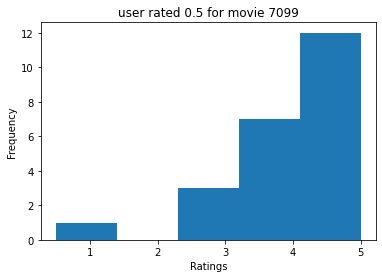

In [124]:
# passing in the series to plot histogram
df.loc[df['movieId'] == 7099, 'rating'].plot.hist(bins=5)

# setting chart title
plt.title('user rated 0.5 for movie 7099')

# setting x-axis label
plt.xlabel('Ratings');

The above histogram seems to indicate that the user for which this was predicted wrongly is an outlier. There is only 1 instance of 0.5 rating, whereas most of the ratings lie between 4-5. Let's repeat this for the next 4 movies with the highest prediction error.

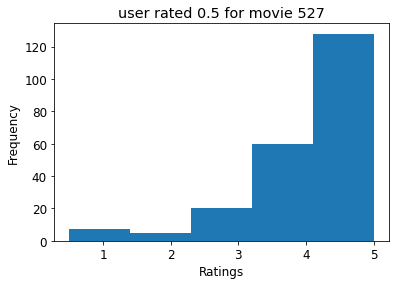

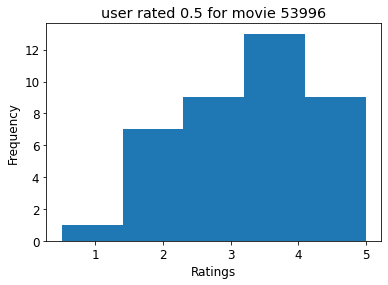

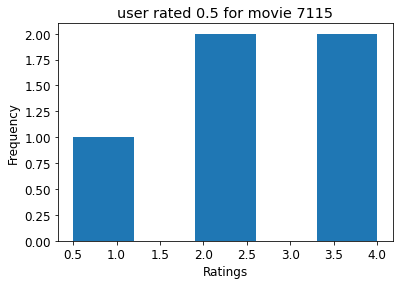

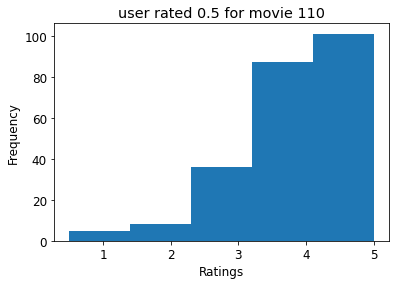

In [130]:
for movieId in worst_10_pred['movieId'].tolist()[1:5]:
    # calling .figure method so that each chart is a separate plot
    plt.figure()
    
    # passing in the series to plot histogram
    df.loc[df['movieId'] == movieId, 'rating'].plot.hist(bins=5)

    # setting chart title
    plt.title(f'user rated 0.5 for movie {movieId}')

    # setting x-axis label
    plt.xlabel('Ratings');

From this, it looks like our `SVD` model is making errors when the user's rating is an outlier compared to the ratings of the rest of the users. This is a possible drawback of this model.

Another reason could also be that ratings mean different things to different users. Some users may wish to be "kinder" and therefore they might give a higher rating of **3.5** to any movie as long as they got at least some enjoyment from it. Other users may be much harsher in terms of their standards for what counts as a "good" or "average" movie. 

1 method to address this, could be mean-centering on a per user basis. i.e. to take a look at the mean rating for the user, and then center the user's mean to 3 by subtracting or adding the difference across all the ratings.

Across the literature in data science, there are [different opinions on whether this truly makes a difference or not](https://link.springer.com/article/10.3758/s13428-015-0624-x#:~:text=Some%20researchers%20say%20that%20it,has%20no%20effect%20on%20multicollinearity.).

After testing out mean-centering on a per user basis, I found that the score with mean centering was **0.8530** and the score we previously obtained was **0.8533**.  made no difference to the `test_rmse` score, so I have omitted that code here.

This shows us that mean_centering all of our users to a 3.5 mean rating per user has not helped us to make much improvements to the model.

---

It is highly likely that we will see more success attempting to create a deep model with contextual features to help us reduce the occurence of this type of error.

## Overall Model Evaluation

## Pros of the SVD model

* The `SVD` model is able to convert the sparse data into two low rank matrix approximation, which can remove noise from the data
* The model was also able to pick up on underlying characteristics of the interactions between users and items. 
* Because of the above first two points, the model can scale to large amounts of data fairly easily. With a larger amount of data, the model's recommendation may be able to be improved.
* The model is able to output predictions very quickly.

## Cons of the SVD Model

* The `SVD` model is only able to extract the feature vectors of `userId`s and `movieId`s. This means that we are likely to lose some meaningful signals, that might not be lost if we use contextual features. Some interesting research is being done in this area to combine the `SVD` model with contextual features, like `CFSVD` etc. [linked here](https://www.sciencedirect.com/science/article/abs/pii/S0045790621003311)
* Transformed data is hard to make sense of, e.g. even though the `SVD` model is able to identify latent underlying features, we don't know what these features are, and we will not be able to map these features either, for example, movie length.
* The SVD algorithm is not able to make predictions for new users that are not already in the training set. This would result in a cold start problem. Our solution to this, was to recommend the top_n movies, based on popularity and rating. This is a common solution to the cold start problem, however, it is not the only solution.
* The SVD algorithm is also not able to handle users that are outliers as we saw during error analysis.

In the next notebook, we will take a look at how we can build a neural network which will allow us to recommend movies to users.